# Data Exploration

In [1]:
import pandas as pd
from obspy import read
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

In [2]:
cat_directory = os.path.join('data', 'lunar', 'training', 'catalogs')
cat_file = os.path.join(cat_directory, 'apollo12_catalog_GradeA_final.csv')
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780,evid00196,impact_mq


In [3]:
test_row = cat.iloc[66]
arrival_time = datetime.strptime(test_row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1974, 6, 25, 0, 23)

In [4]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = test_row['time_rel(sec)']
arrival_time_rel

1380

In [5]:
filename = test_row.filename
filename

'xa.s12.00.mhz.1974-06-25HR00_evid00149'

In [6]:
data_directory = os.path.join('data', 'lunar', 'training', 'data', 'S12_GradeA')
len(os.listdir(data_directory))//2

76

In [7]:
mseed_file = os.path.join(data_directory, filename + '.mseed')
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1974-06-25T00:00:00.524000Z - 1974-06-26T00:00:03.844755Z | 6.6 Hz, 572423 samples

In [8]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1974-06-25T00:00:00.524000Z
         endtime: 1974-06-26T00:00:03.844755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [9]:
tr_times = st[0].times()
tr_data = st[0].data
sampling_rate = st[0].stats.sampling_rate

In [10]:
tr_data.max()

4.16686189152675e-09

In [11]:
tr_data.min()

-3.9152096840609555e-09

In [528]:
def plot_signal(tr_times, tr_data, arrival_time_rel=None, title=None):
    # Plot the time series and spectrogram
    fig = plt.figure(figsize=(10, 4))
    ax = plt.subplot(1, 1, 1)
    
    # Plot trace
    ax.plot(tr_times, tr_data)
    if title:
        ax.set_title(title, fontweight='bold')
    
    # Mark detection
    if arrival_time_rel:
        ax.axvline(x = arrival_time_rel, color='red', label='Detection')
        ax.legend(loc='upper left')
    
    # Make the plot pretty
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')

/tmp/ipykernel_7767/4263409786.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 4))


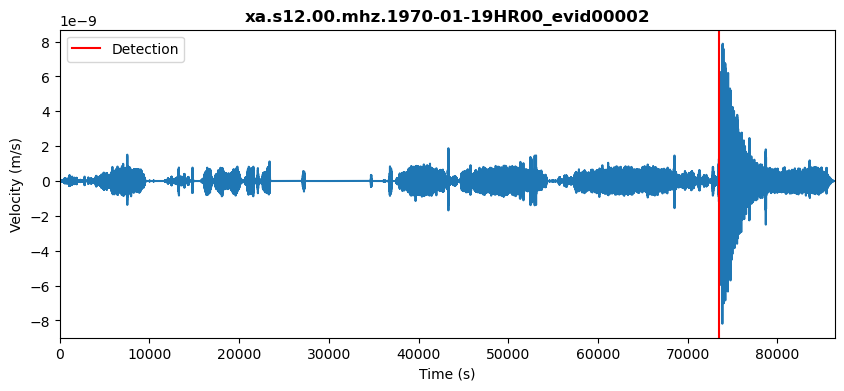

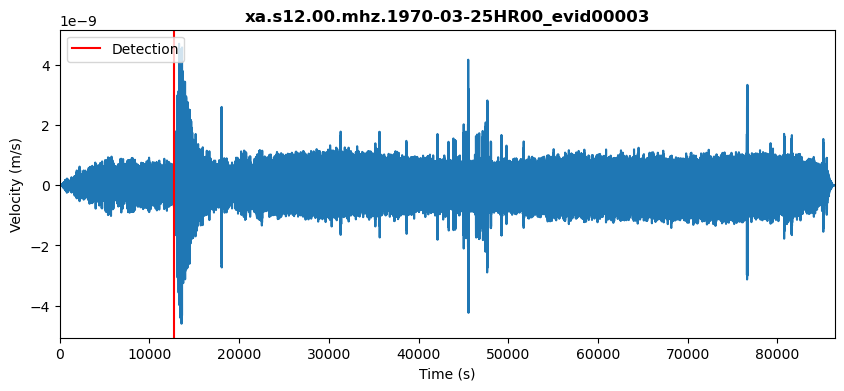

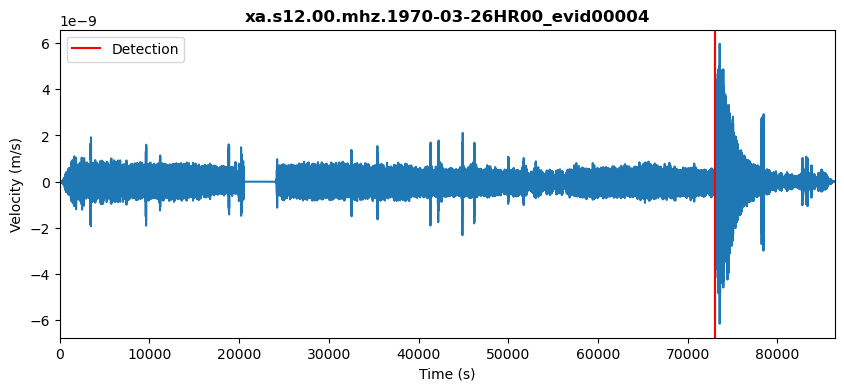

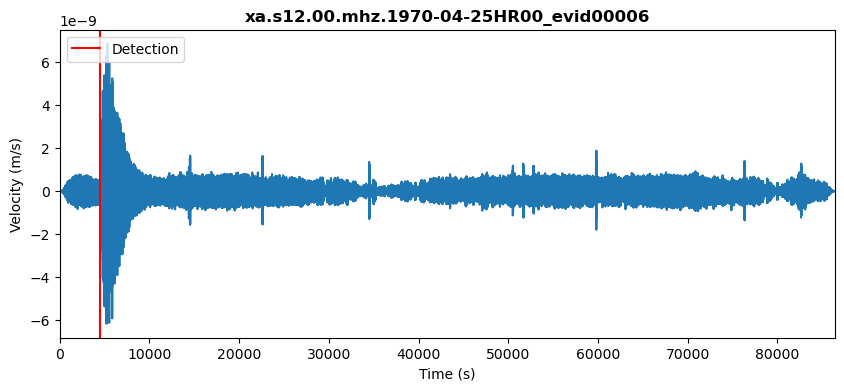

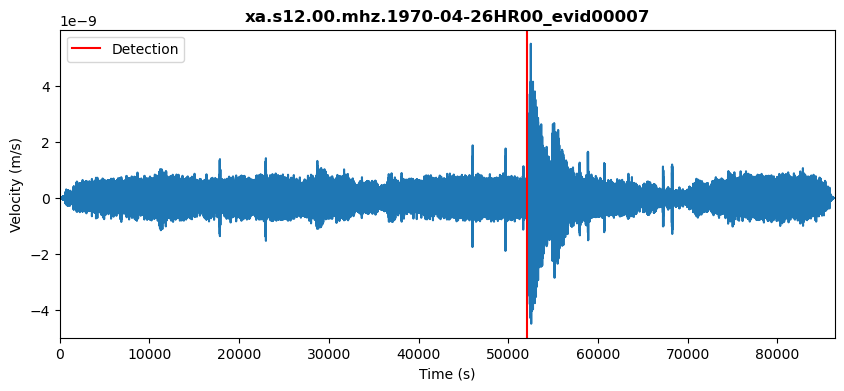

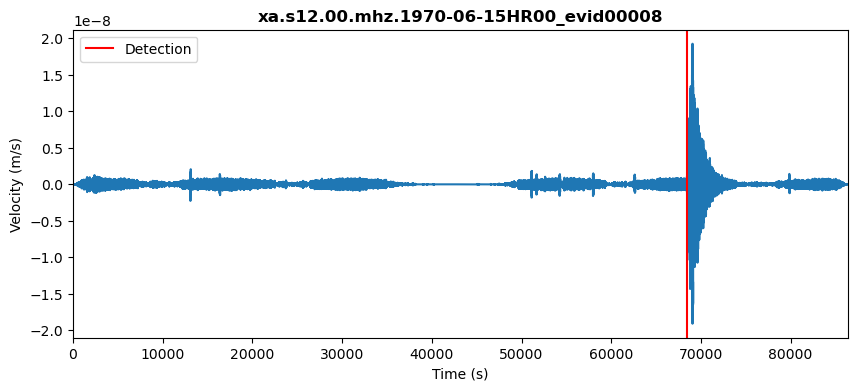

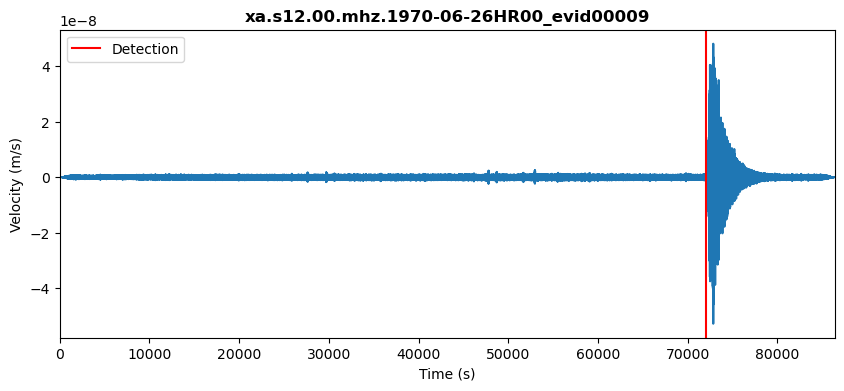

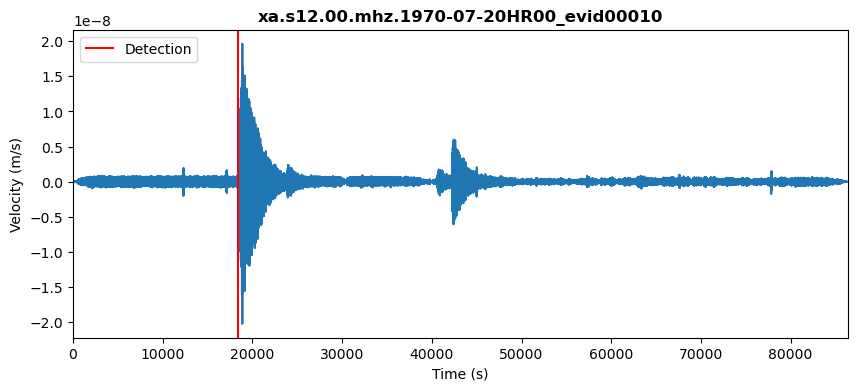

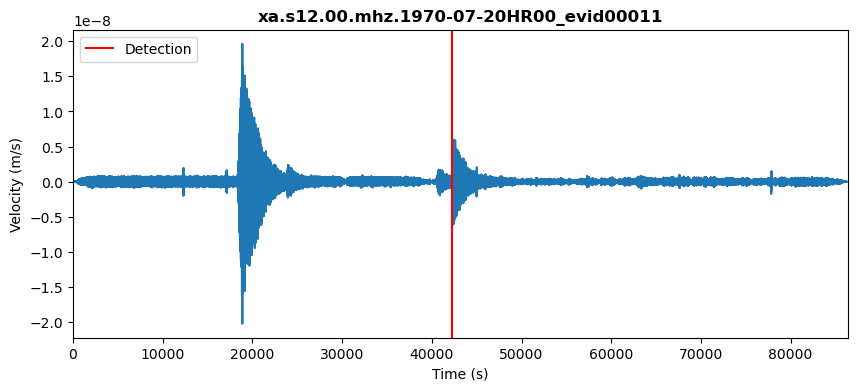

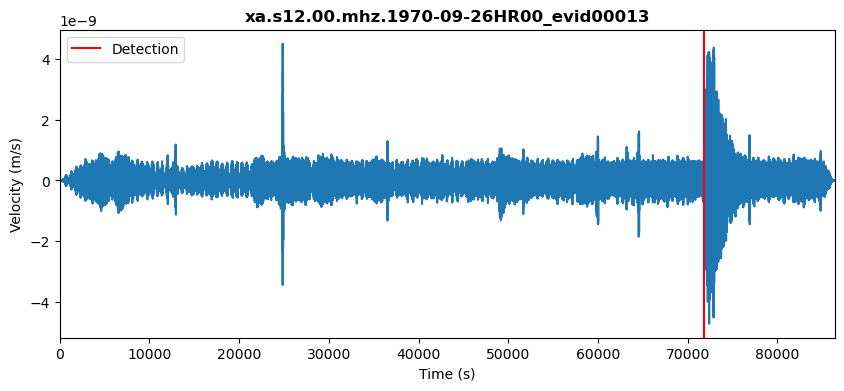

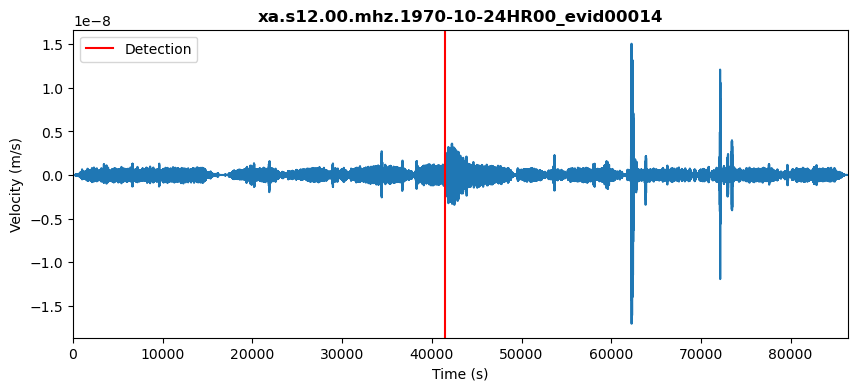

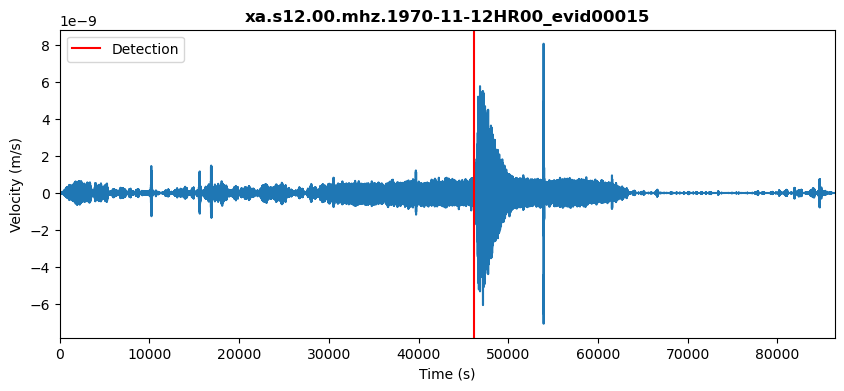

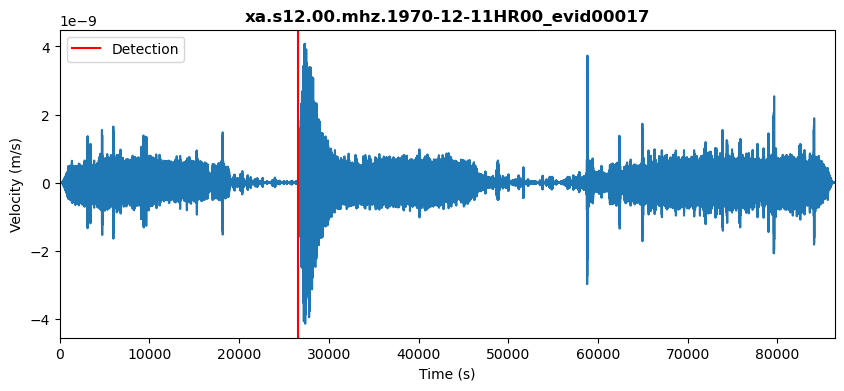

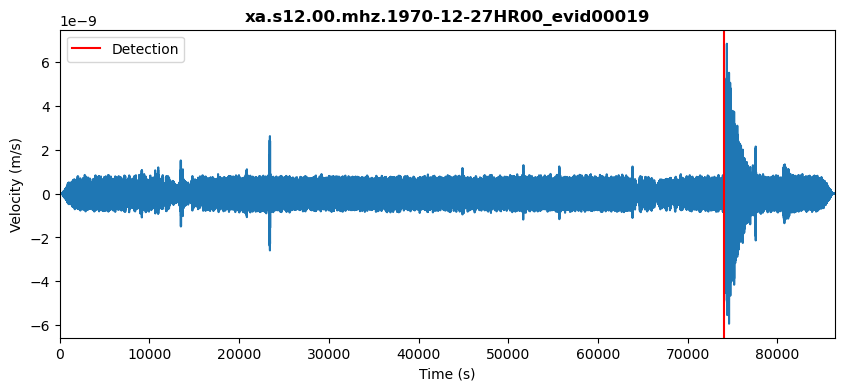

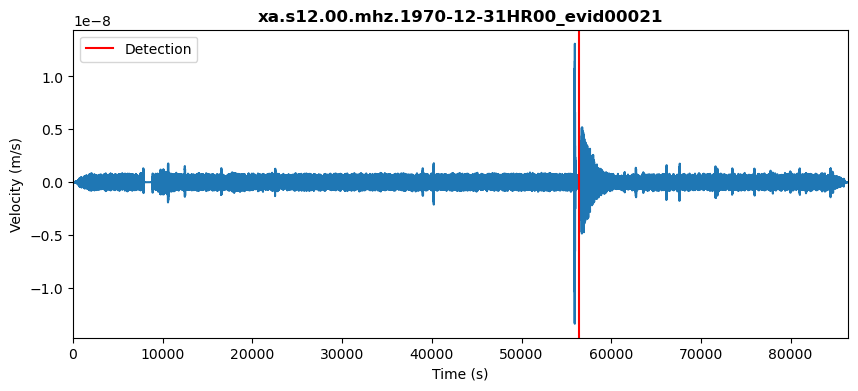

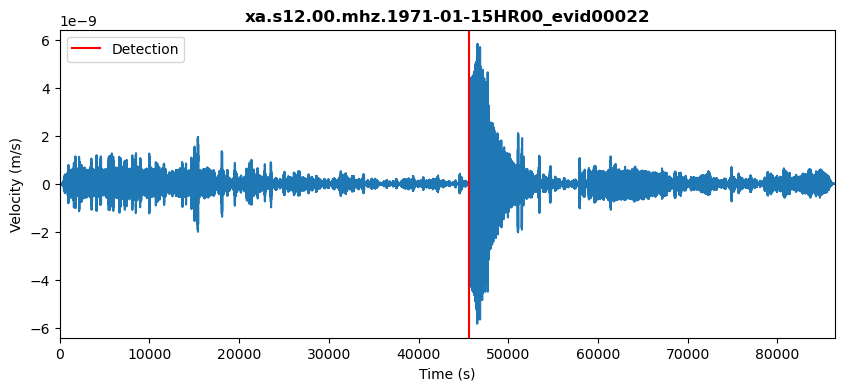

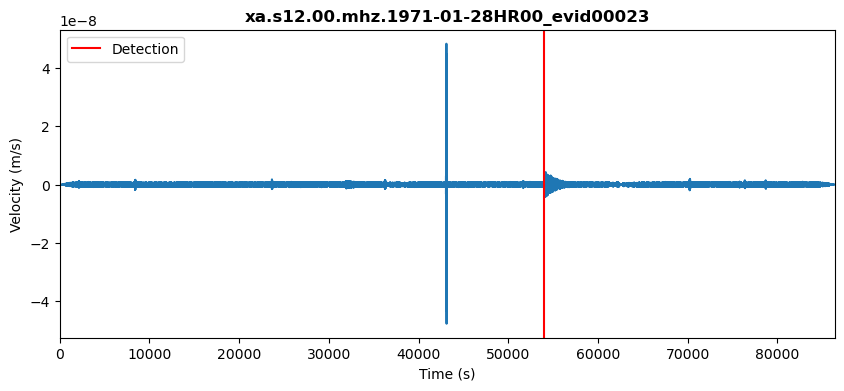

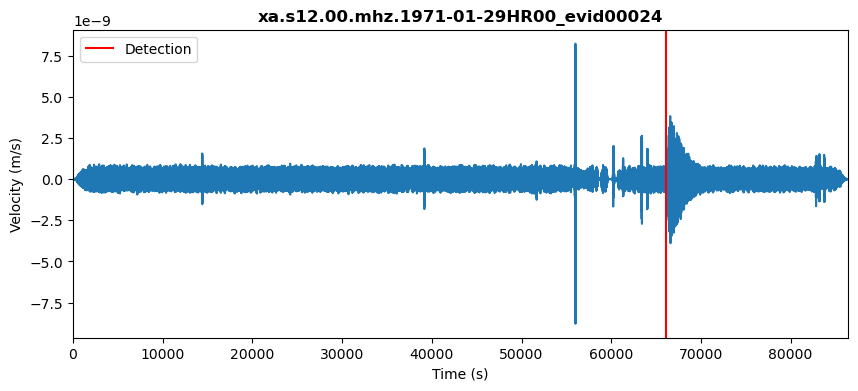

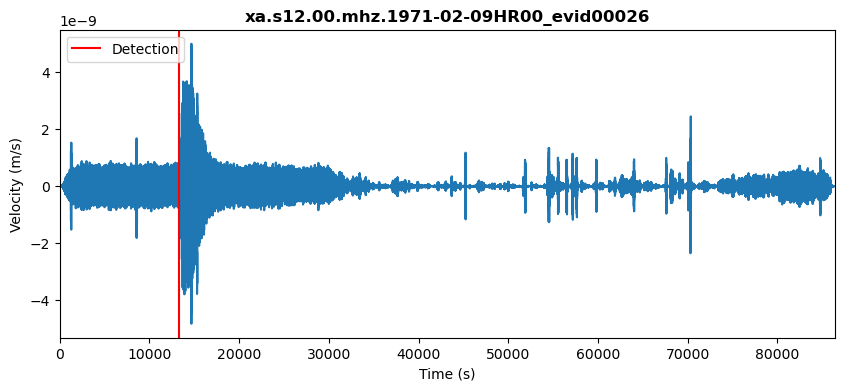

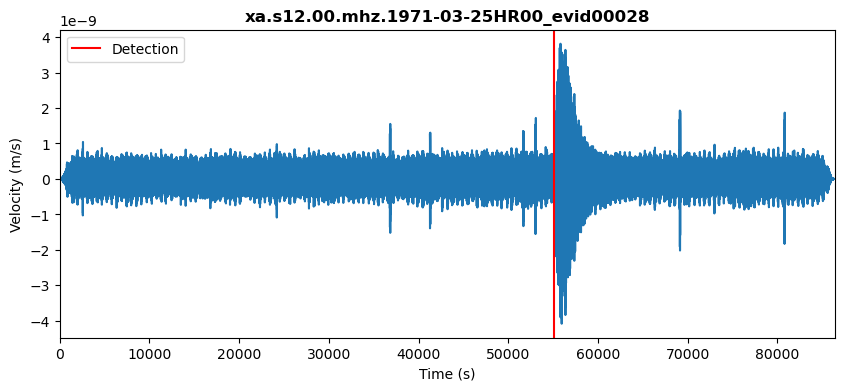

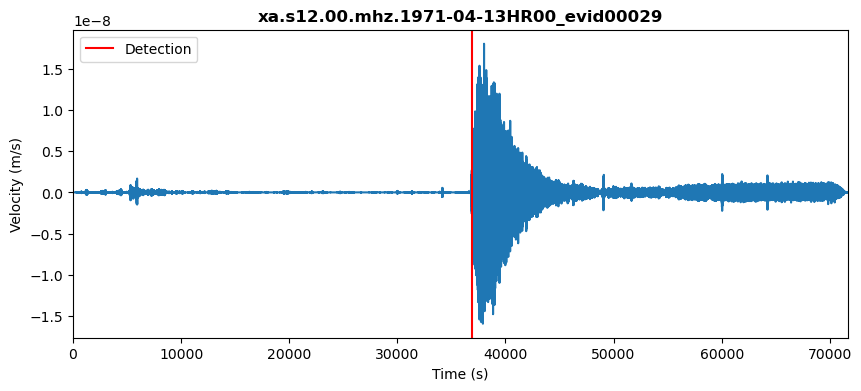

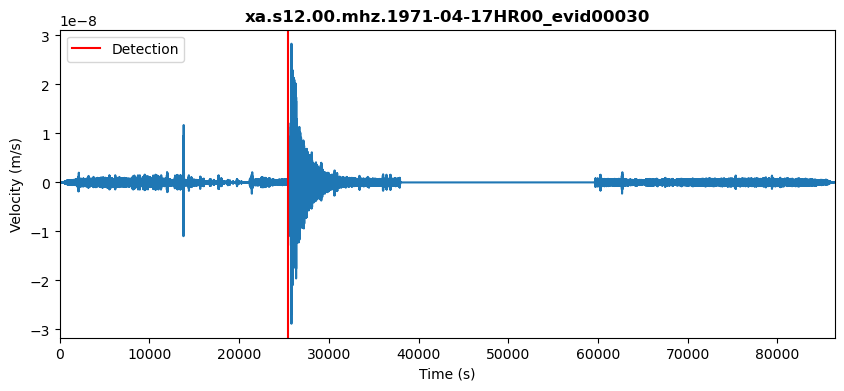

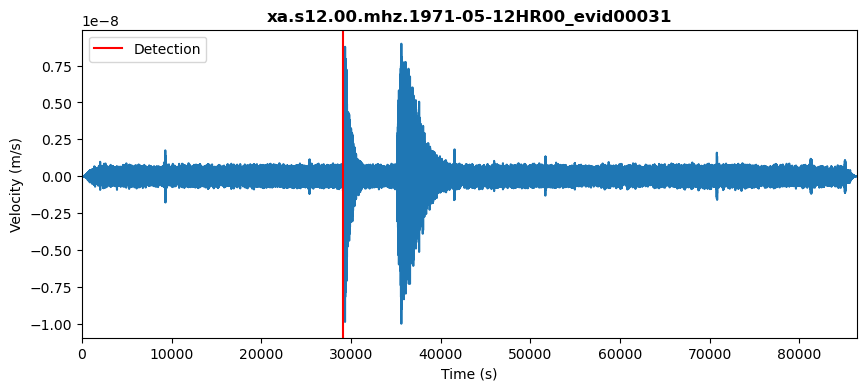

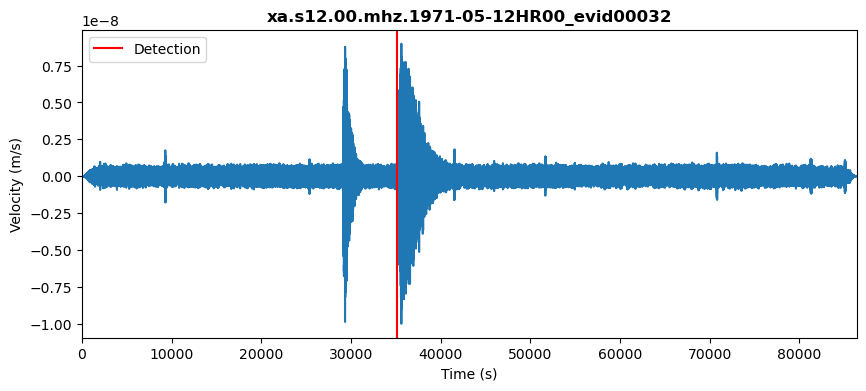

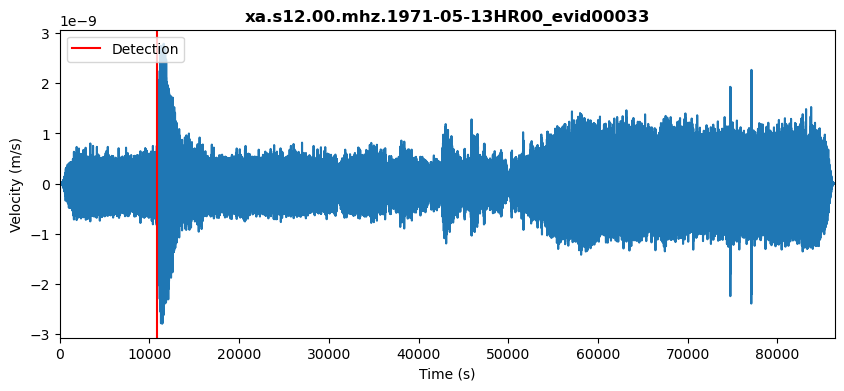

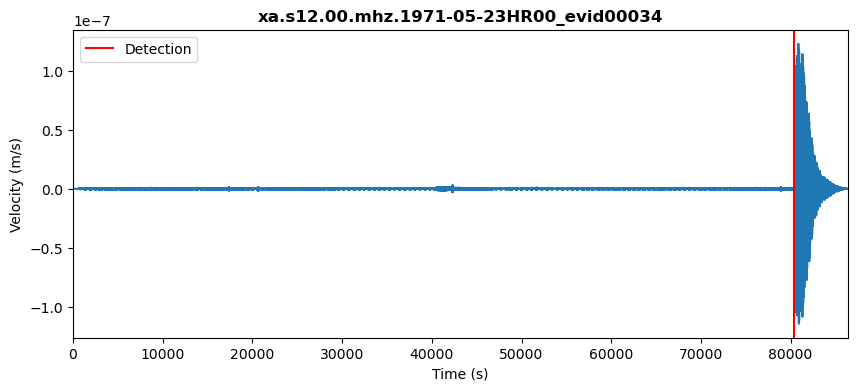

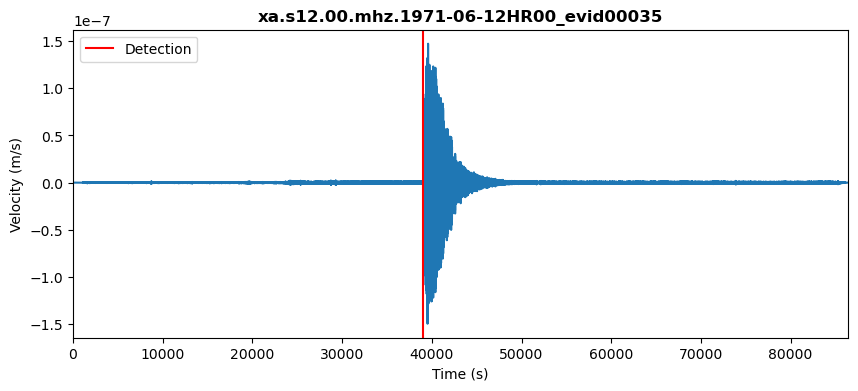

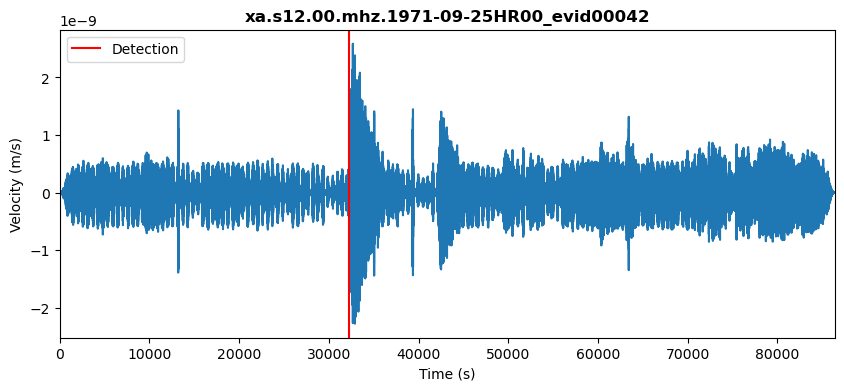

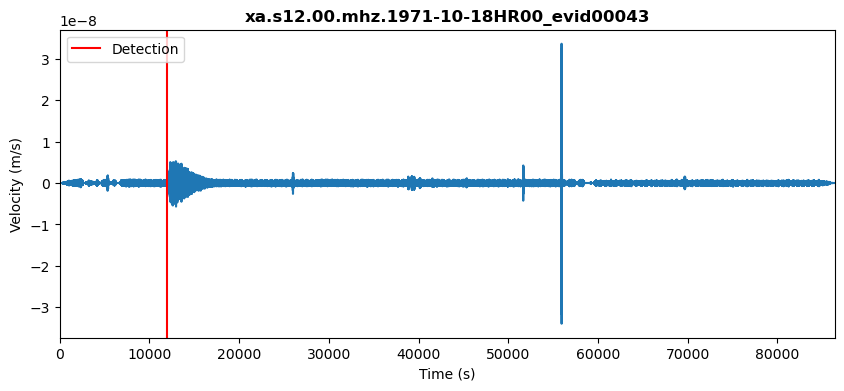

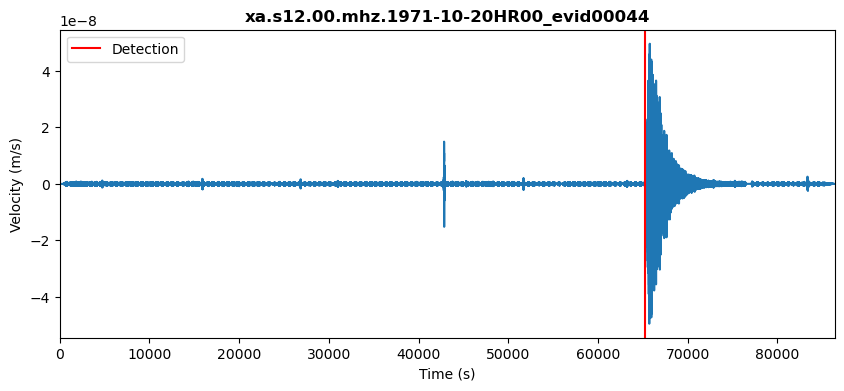

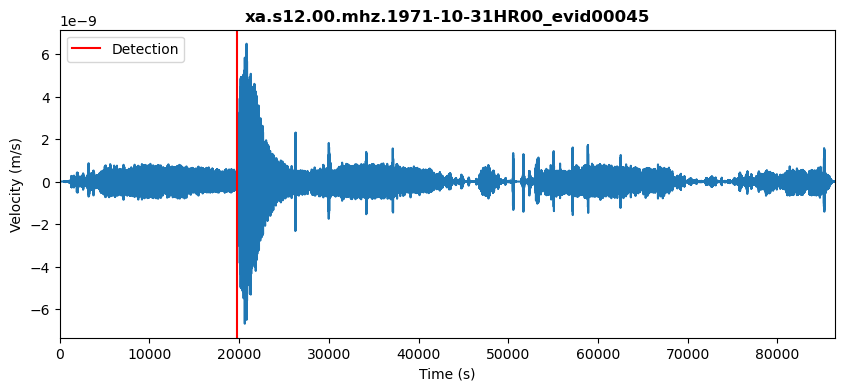

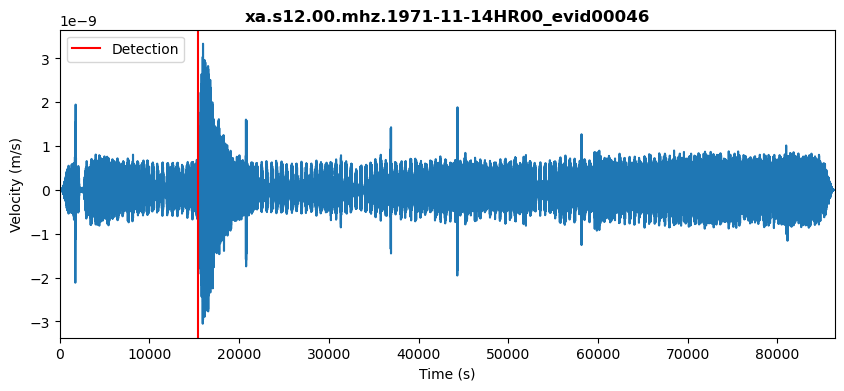

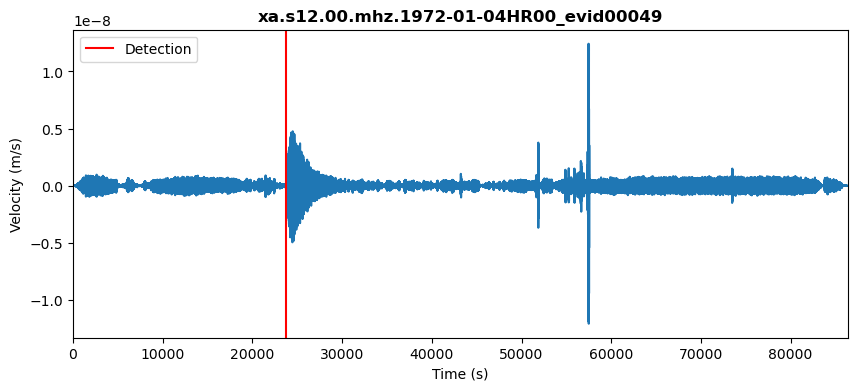

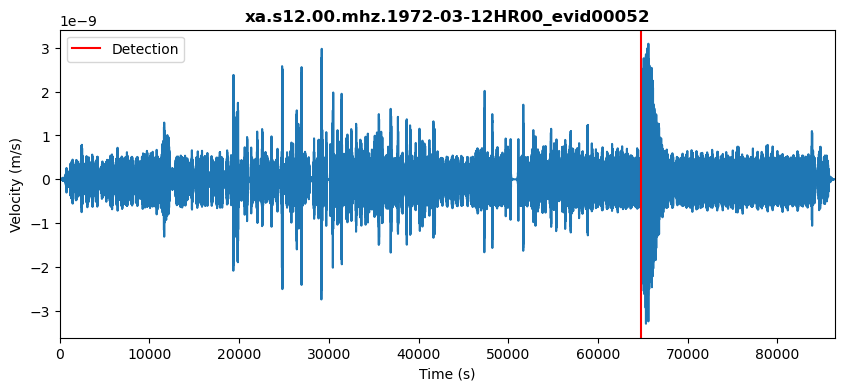

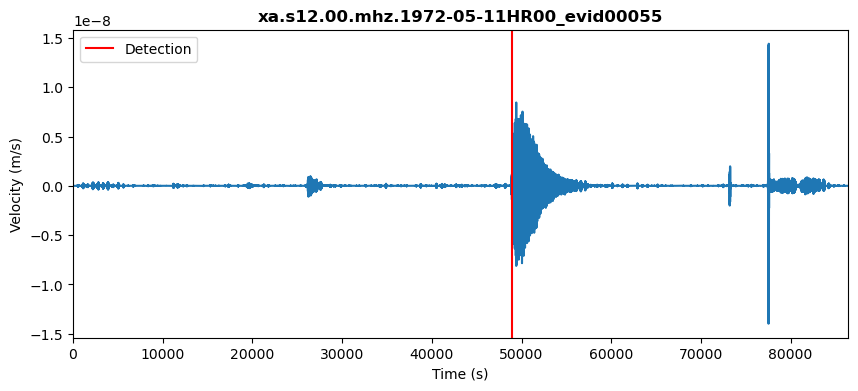

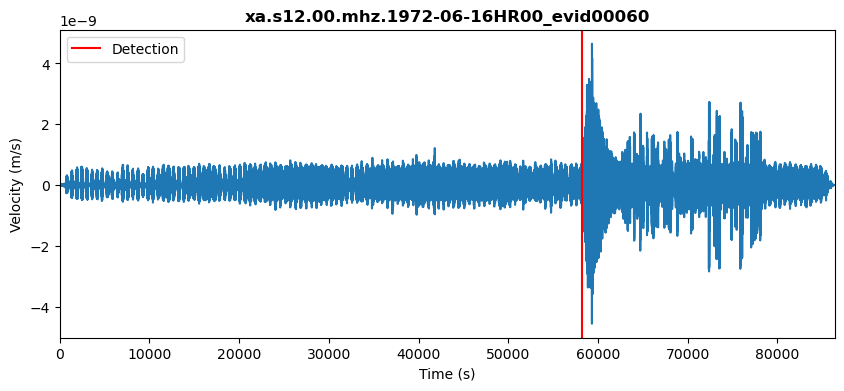

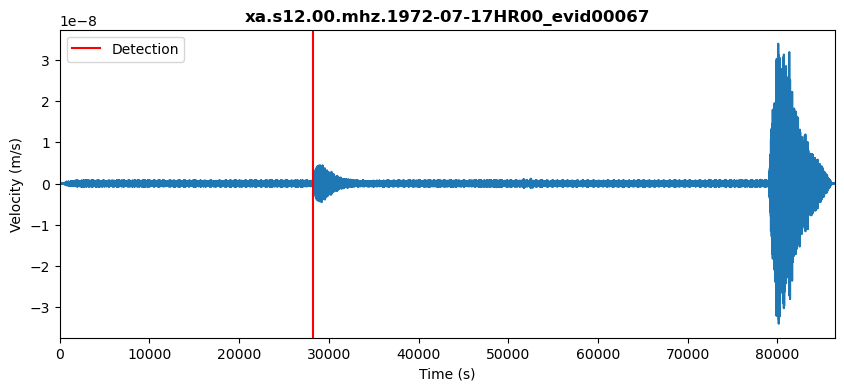

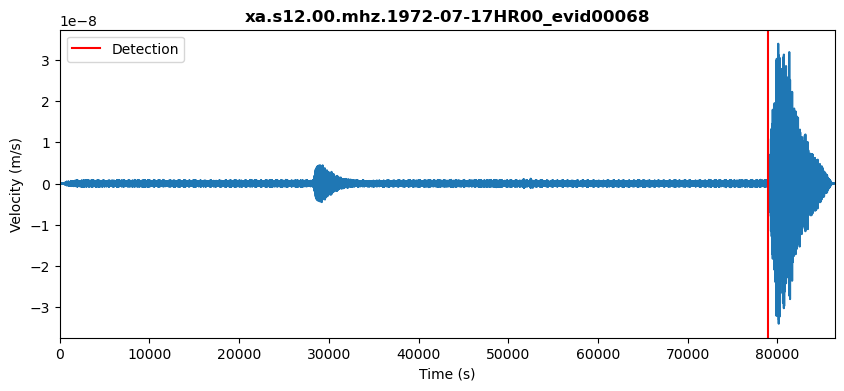

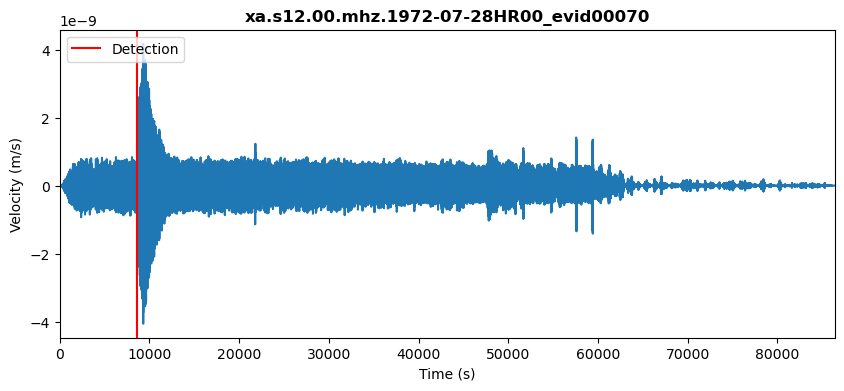

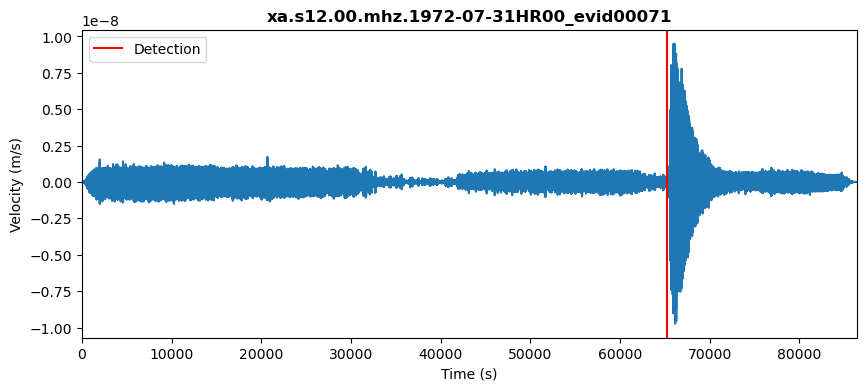

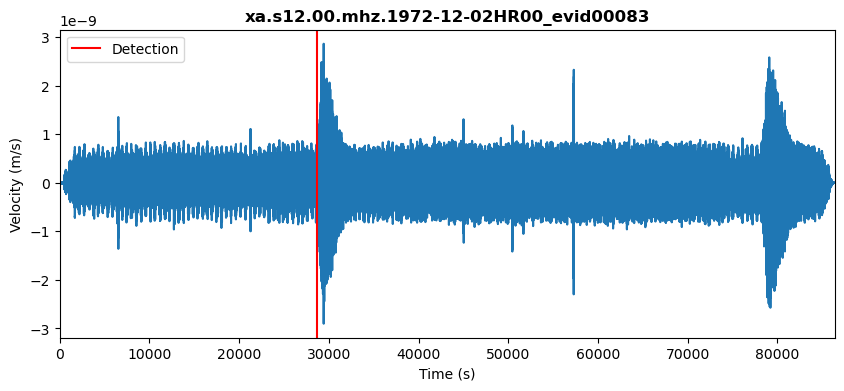

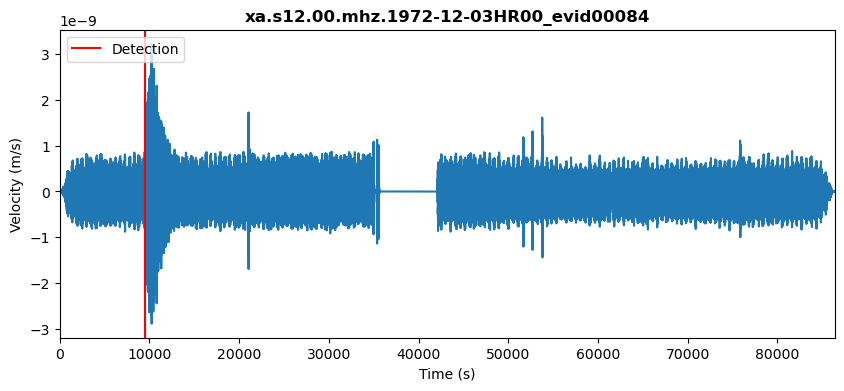

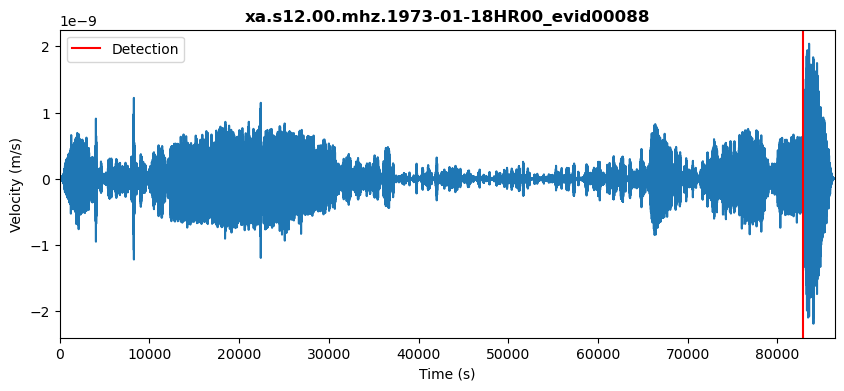

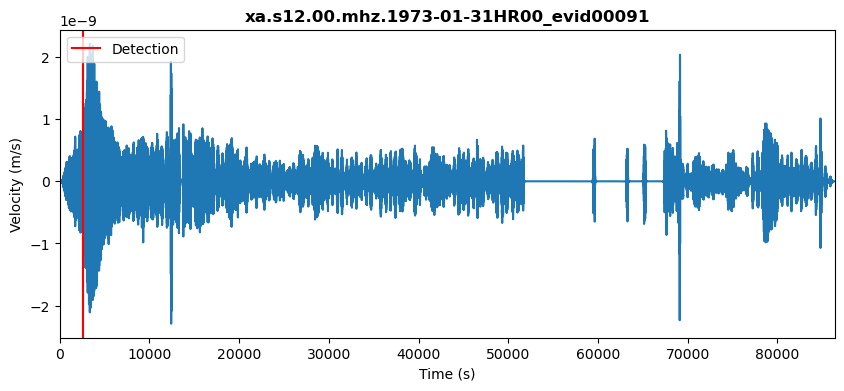

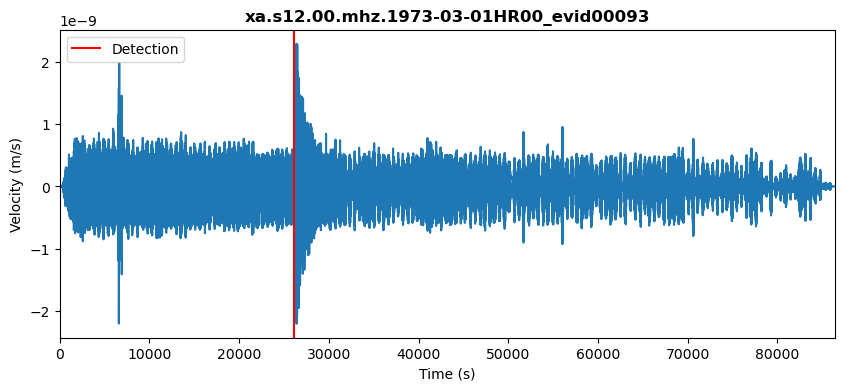

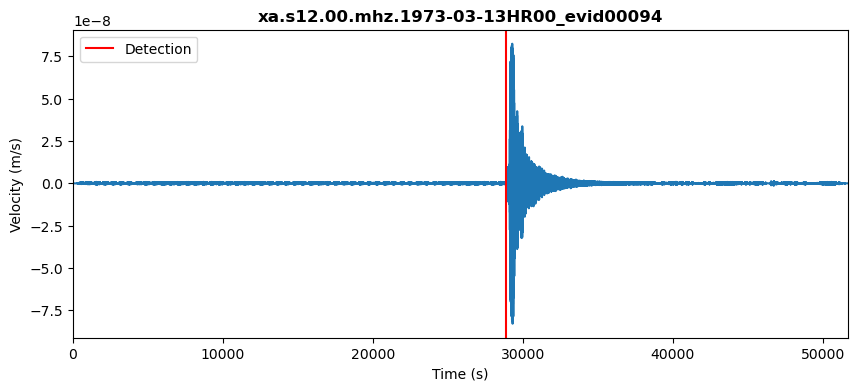

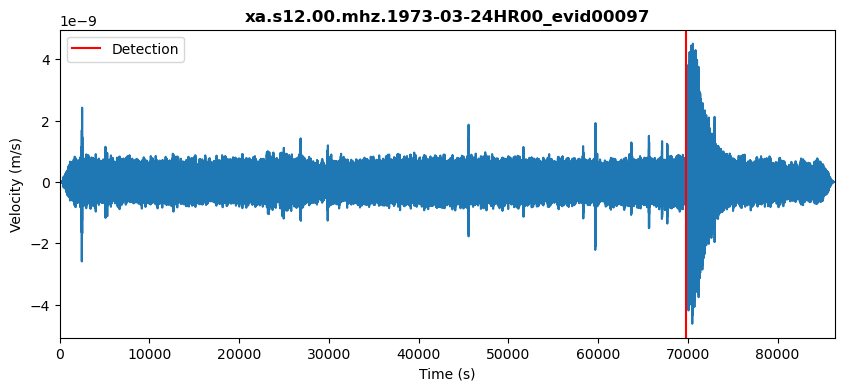

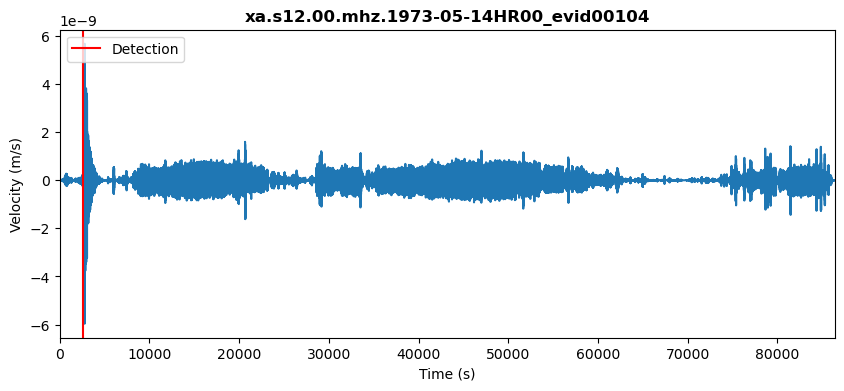

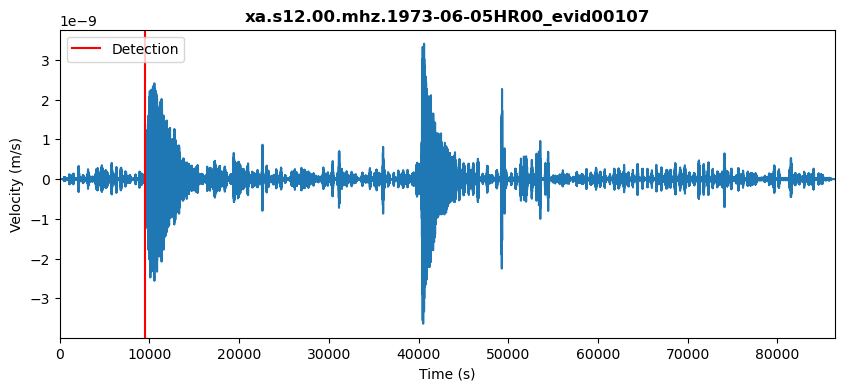

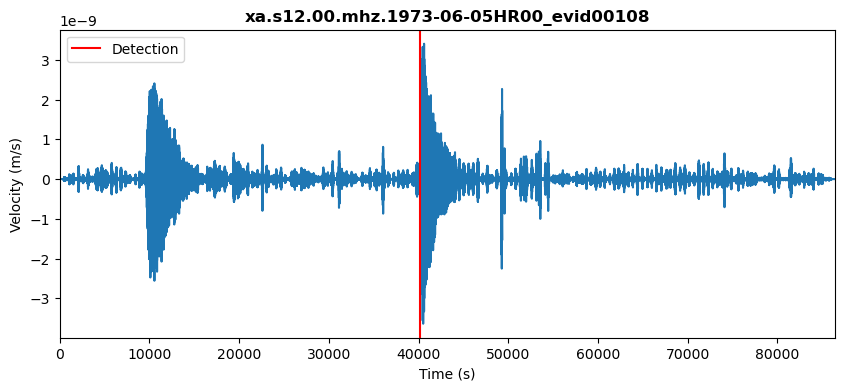

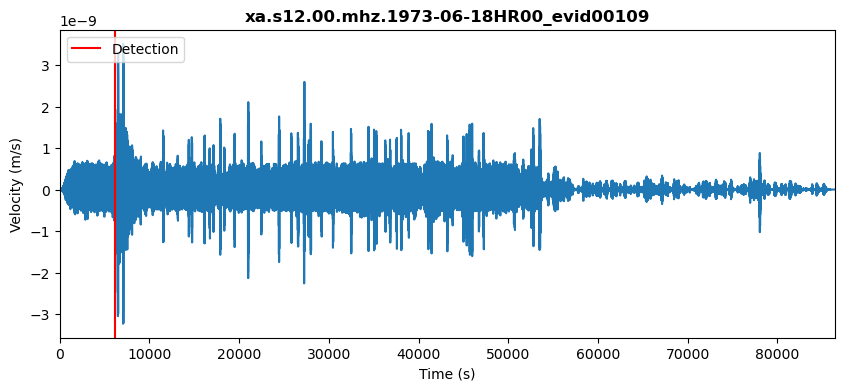

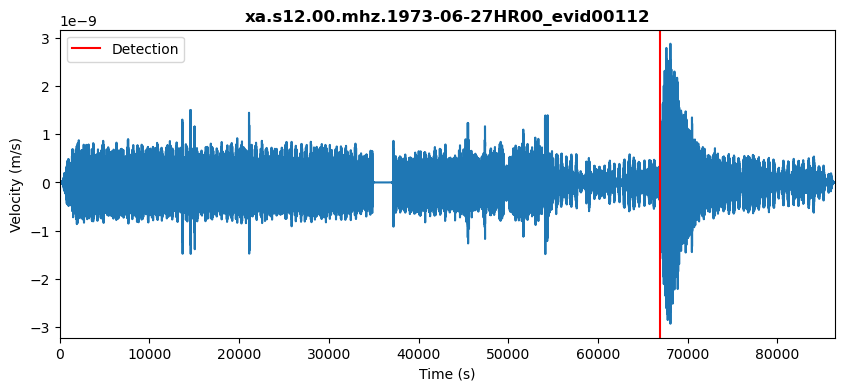

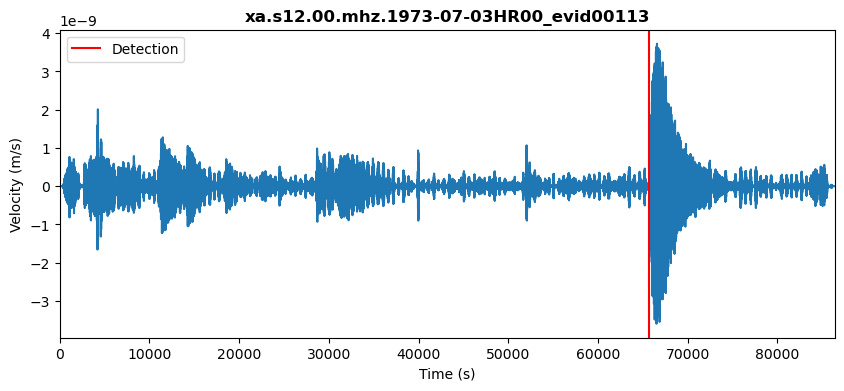

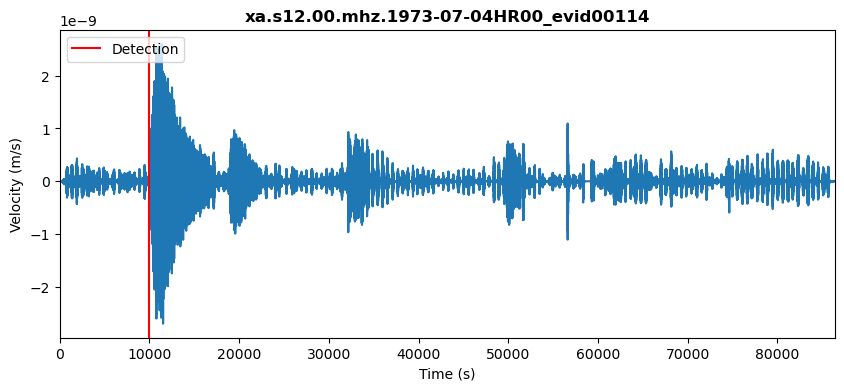

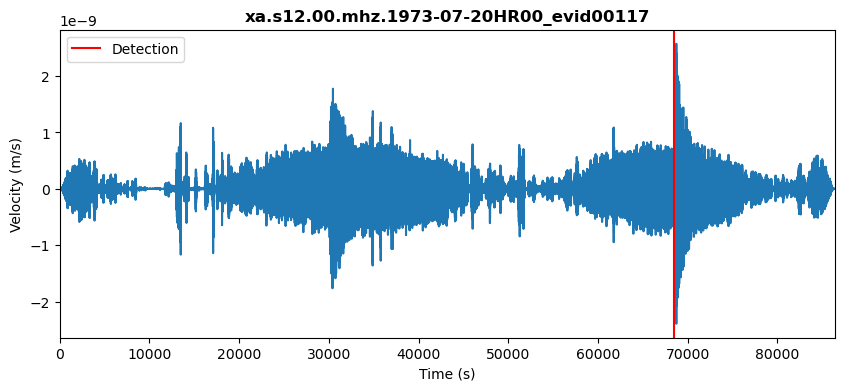

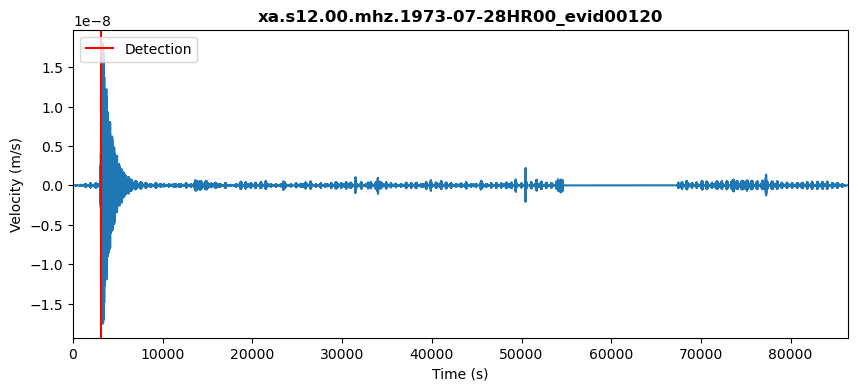

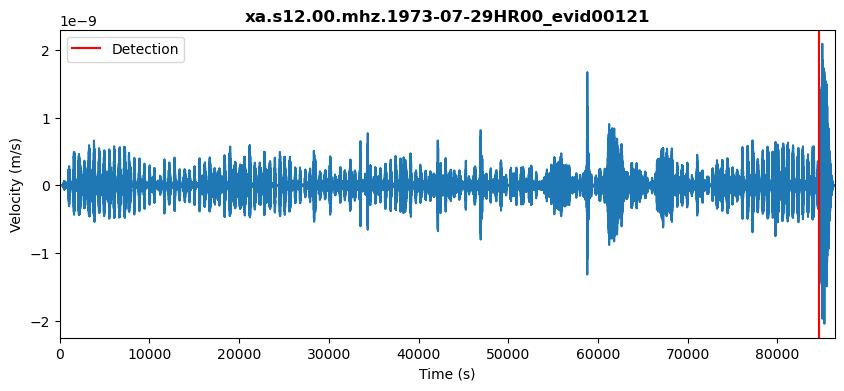

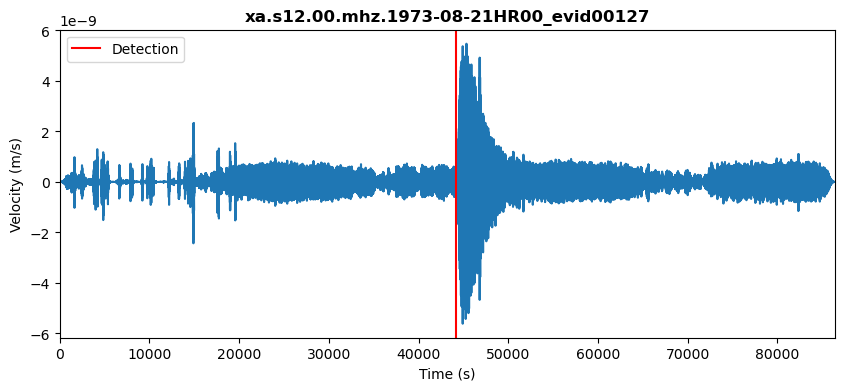

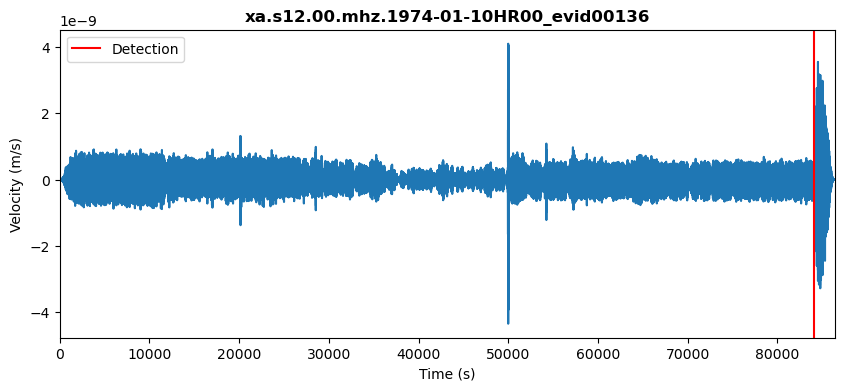

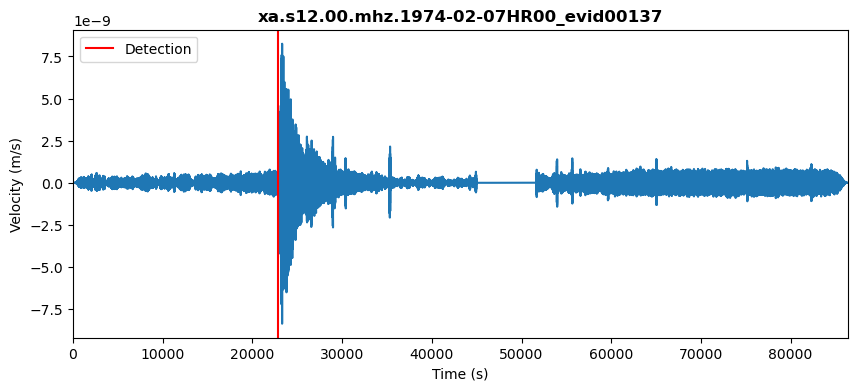

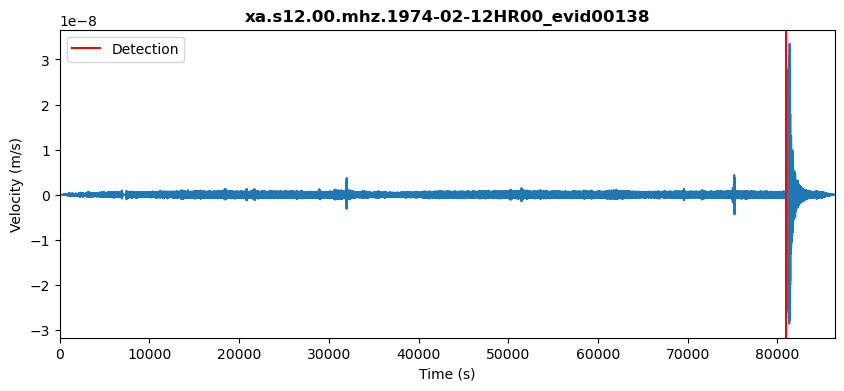

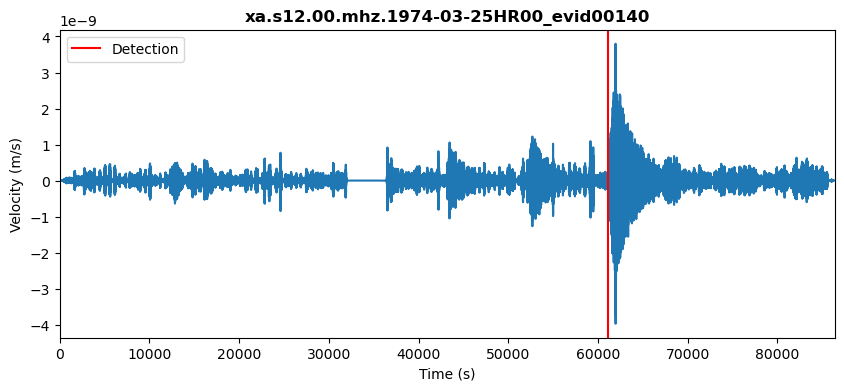

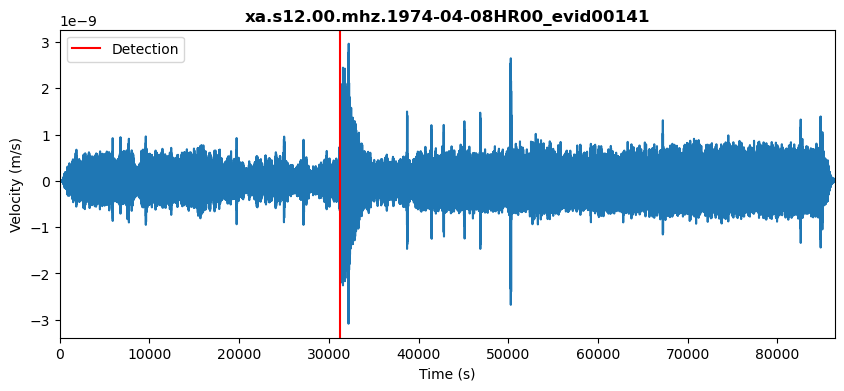

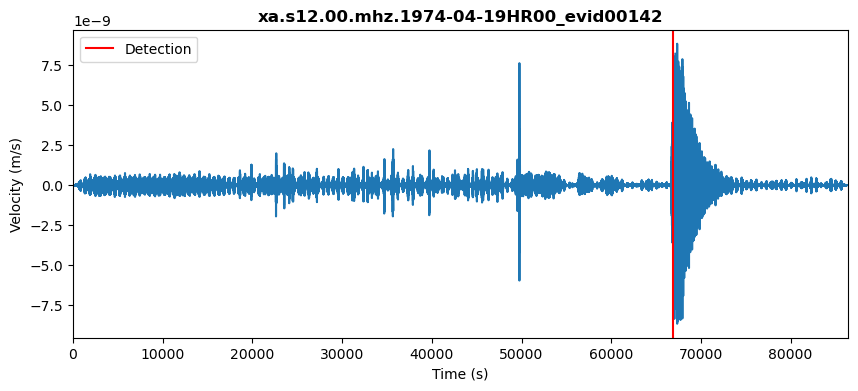

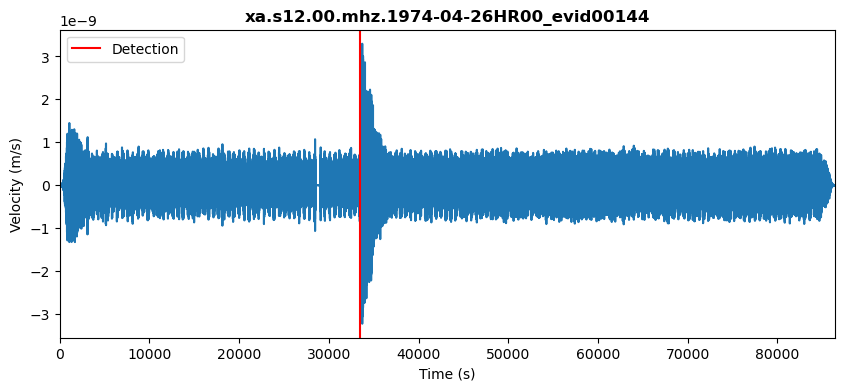

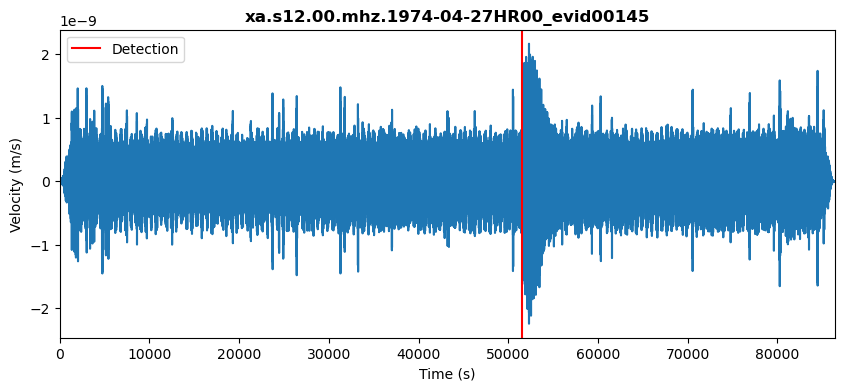

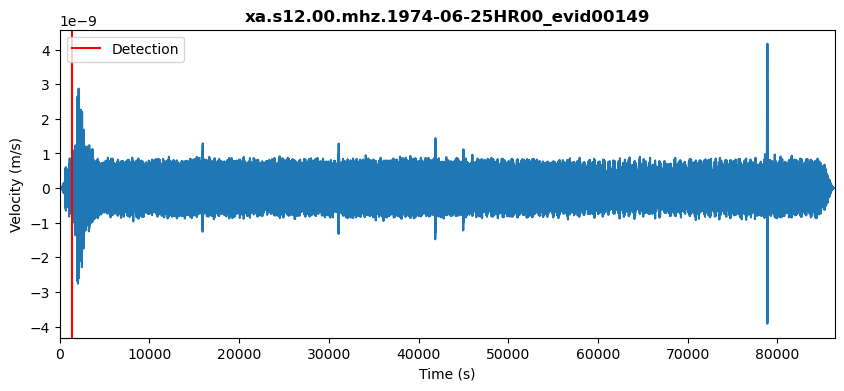

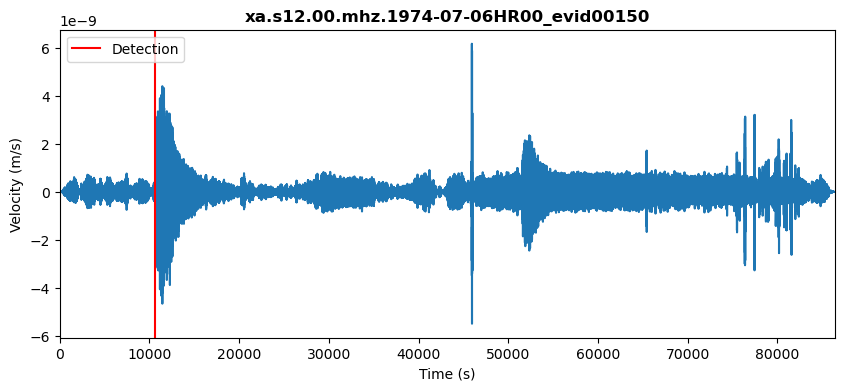

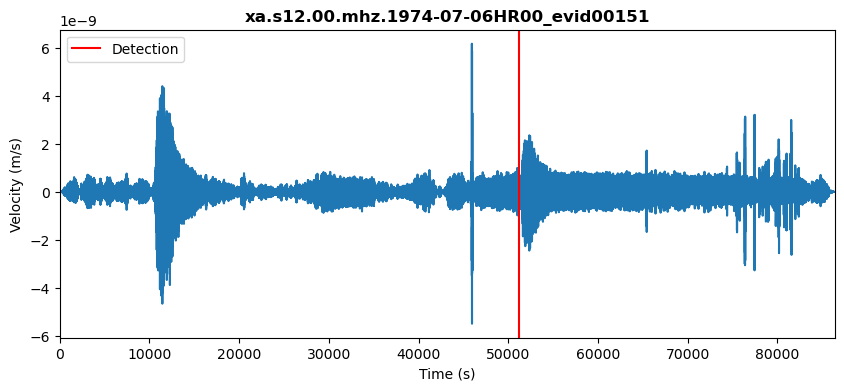

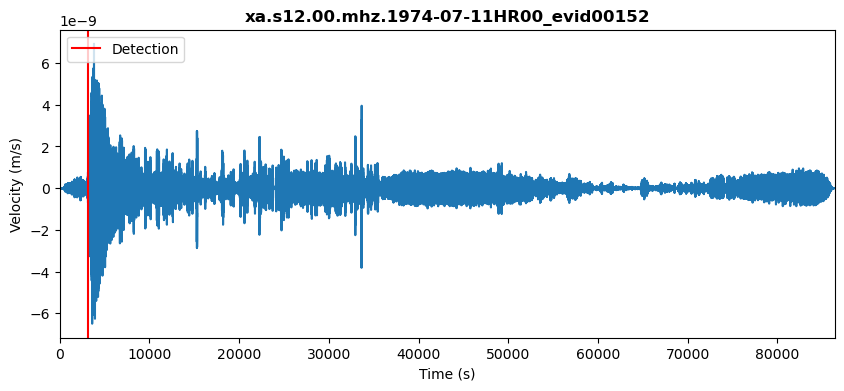

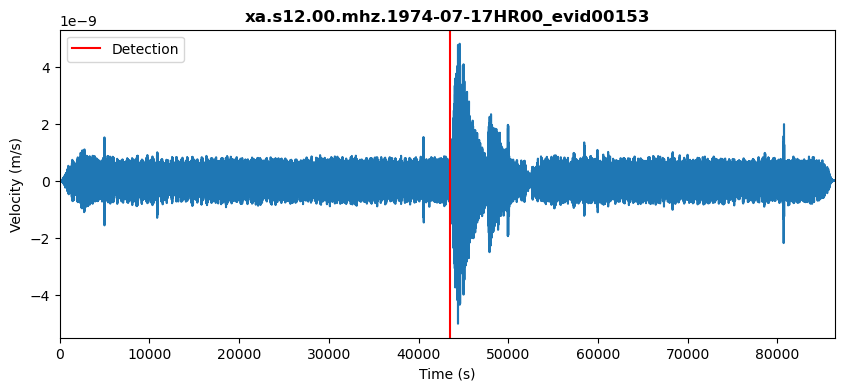

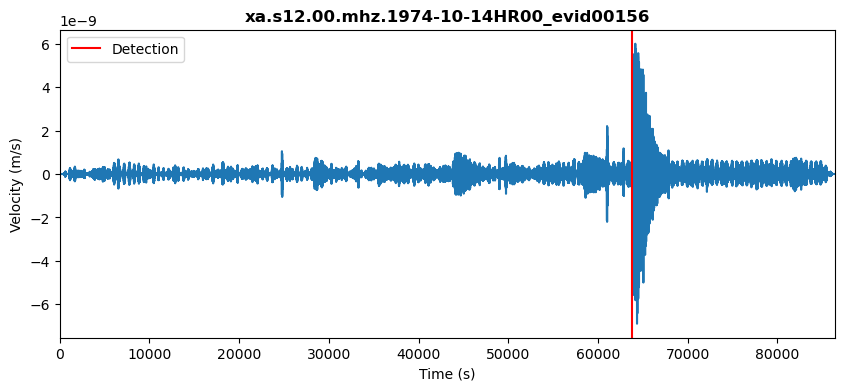

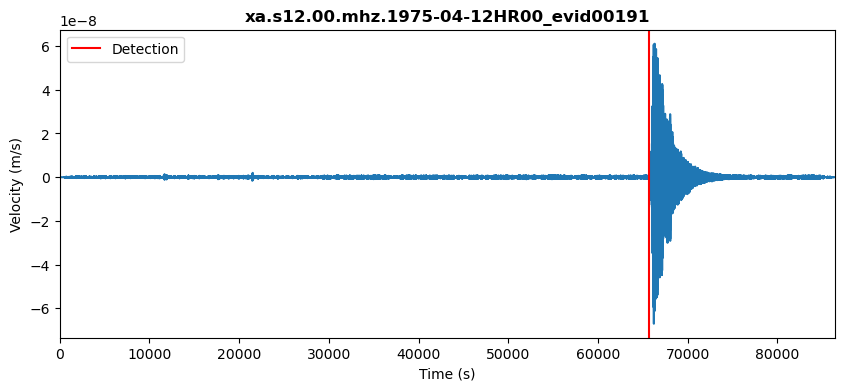

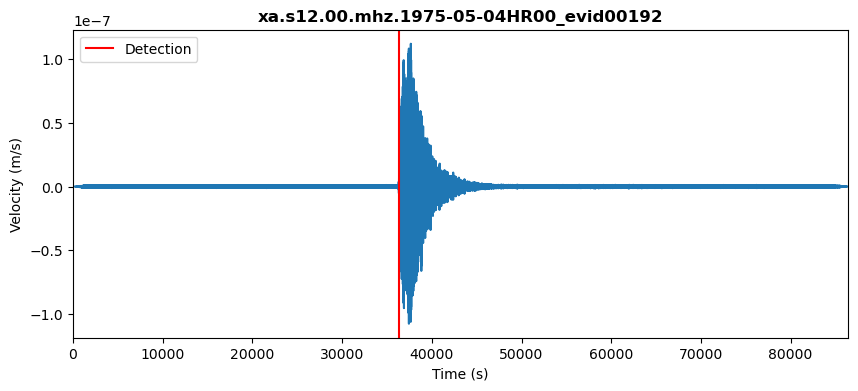

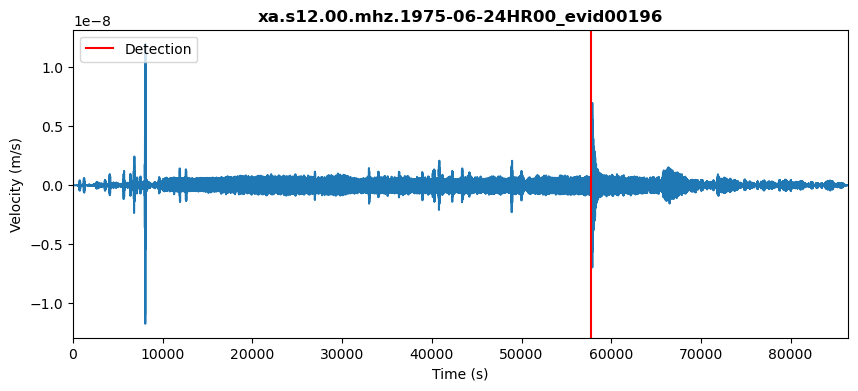

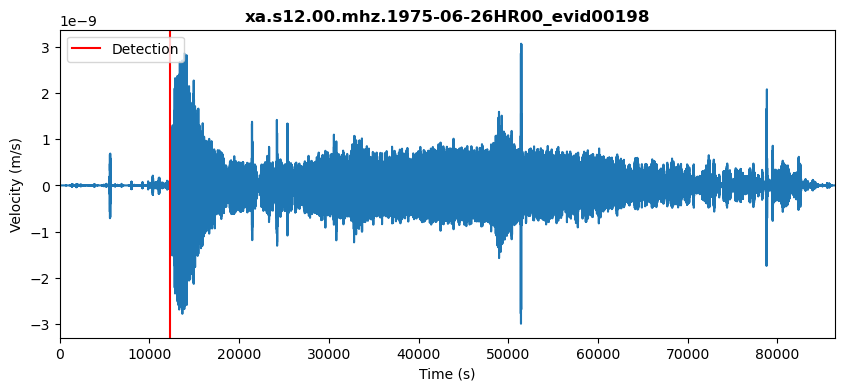

In [631]:
for row in cat.iterrows():
    row = row[1]
    file = row.filename
    time_rel = row['time_rel(sec)']  # arrival_time_rel
    tr = read(os.path.join(data_directory, file+'.mseed')).traces[0]
    plot_signal(tr.times(), tr.data, time_rel, file)

# Signal Denoising

In [15]:
from matplotlib import cm
import numpy as np
from numpy.fft import rfft, rfftfreq, irfft

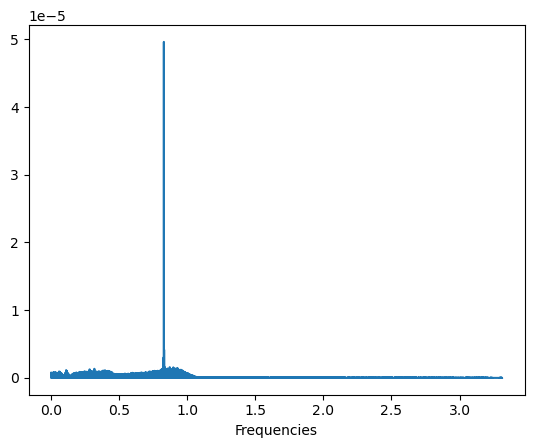

In [16]:
yf = rfft(tr_data)  # fourier
xf = rfftfreq(tr_data.size, 1/sampling_rate)  # Frequencies

plt.plot(xf, np.abs(yf))
plt.xlabel('Frequencies')
plt.show()

In [18]:
def filter_signal(tr, threshold=0.8, norm=True):
    fourier = rfft(tr.data)
    frequencies = rfftfreq(tr.data.size, d=1/tr.stats.sampling_rate)
    fourier[frequencies > threshold] = 0
    new_data = irfft(fourier)
    if norm:
        new_data = (new_data-new_data.min())/(new_data.max()-new_data.min())
    return new_data, tr.times()[:len(new_data)]

In [19]:
filtered_data, times = filter_signal(st[0], norm=False)

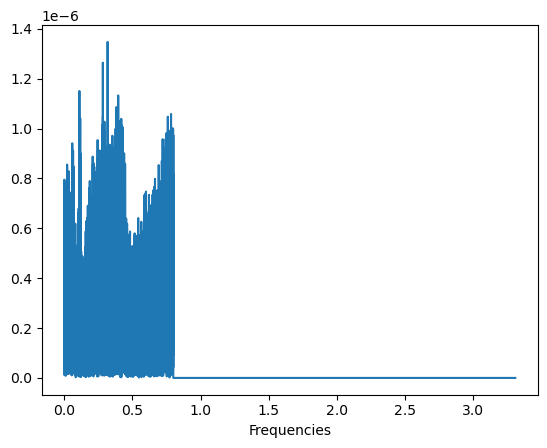

In [20]:
yf = rfft(filtered_data)  # fourier
xf = rfftfreq(filtered_data.size, 1/sampling_rate)  # Frequencies

plt.plot(xf, np.abs(yf))
plt.xlabel('Frequencies')
plt.show()

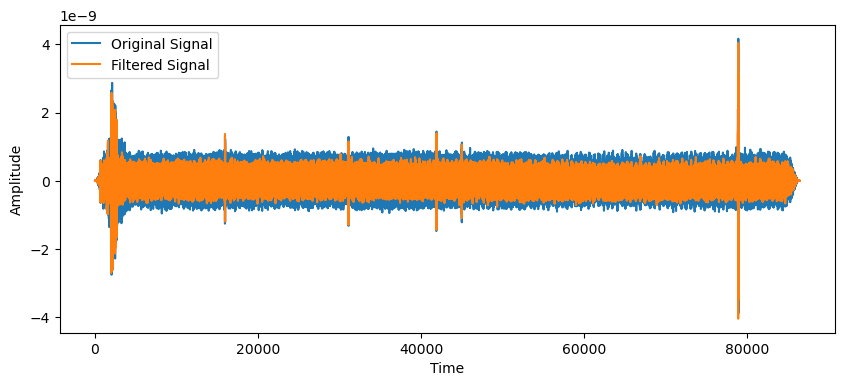

In [21]:
plt.figure(figsize=(10, 4))

plt.plot(tr_times, tr_data, label='Original Signal')
plt.plot(times, filtered_data, label='Filtered Signal')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
# plt.grid(True)

plt.show()

# Features Extraction

In [22]:
from librosa.feature import mfcc
from scipy.signal import spectrogram

## Spectrogram

In [27]:
offset = int(arrival_time_rel*sampling_rate)
arrival_frame = filtered_data[offset-1600:offset+1600]
arrival_frame.shape

(3200,)

In [28]:
f, t, spect = spectrogram(arrival_frame, sampling_rate)

**ndarray f:**
    Array of sample frequencies.
<br>**ndarray t:**
    Array of segment times.
<br>**ndarray Sxx:**
    Spectrogram of x. By default, the last axis of Sxx corresponds
    to the segment times.

(129, 14)

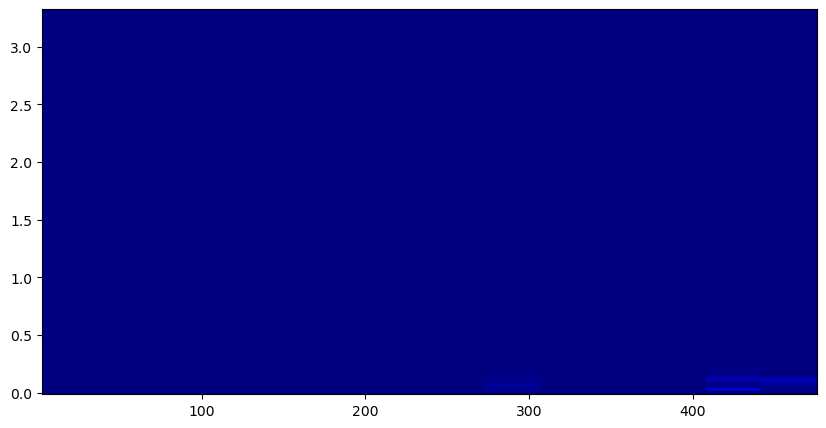

In [32]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, spect, cmap=cm.jet, vmax=5e-17).get_array().shape

In [33]:
f, t, sp = spectrogram(filtered_data, sampling_rate)

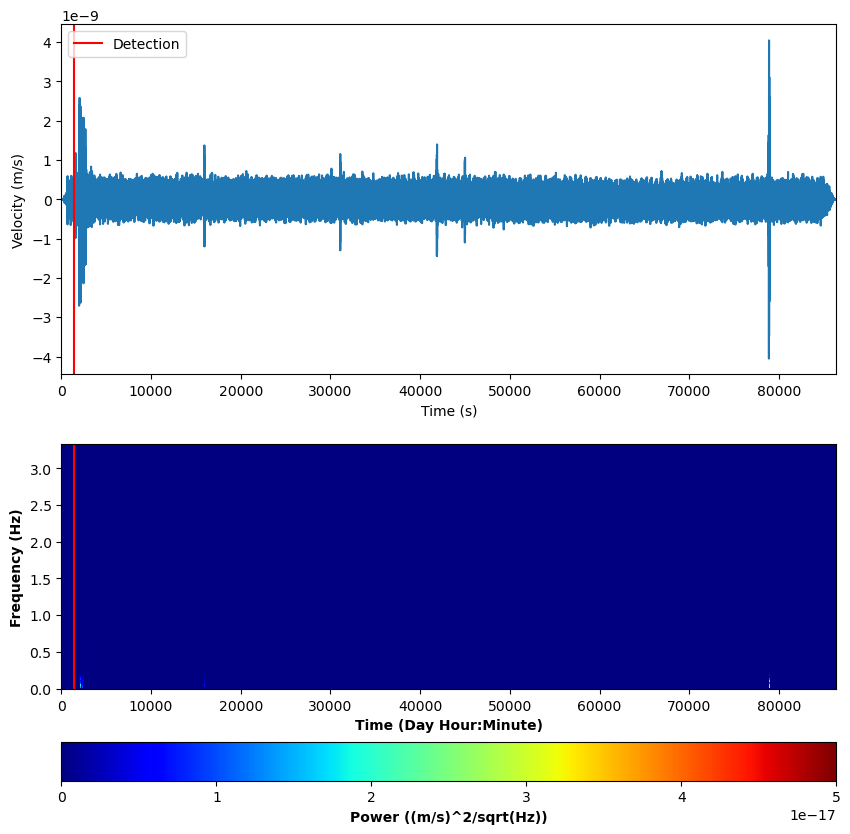

In [34]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(times, filtered_data)
# Mark detection
ax.axvline(x = arrival_time_rel, color='red', label='Detection')
ax.legend(loc='upper left')
# Make the plot pretty
ax.set_xlim([min(times), max(times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')


ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sp, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(times), max(times)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival_time_rel, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

## Mel Frequency Cepstral Coefficients (MFCC)

In [163]:
# coefs = np.mean(
#     mfcc(y=arrival_frame*1e9, sr=sampling_rate, n_mfcc=265).T, axis=0
# )
# coefs.shape

(128,)

In [ ]:
# coefs

# Data Generation and Preparation

In [164]:
window = int(sampling_rate * 60 * 15)  # 15 Minuts
window

5962

In [42]:
from tqdm import tqdm

In [43]:
def plot_point(tr_time, tr_data, pts, title, arr=None):
    # Plot the time series and spectrogram
    fig = plt.figure(figsize=(10, 4))
    ax = plt.subplot(1, 1, 1)
    
    # Plot trace
    ax.plot(tr_time, tr_data)
    ax.set_title(title, fontweight='bold')
    
    # Mark detection
    for i in range(len(pts)):
        ax.axvline(x = pts[i], color='red')

    if arr: ax.axvline(x = arr, color='green')
        
    
    # Make the plot pretty
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')

In [315]:
def gen_pos_data(tr, arrival_time_rel, arrival_time, window):

    starting_points = int(arrival_time_rel), int(arrival_time_rel-window/4), int(arrival_time_rel+window/4)
    
    x, y, ft, spects = [], [], [], []
    
    filtered, _ = filter_signal(tr)
    for point in starting_points:
        f, t, sp = spectrogram(filtered[point:point+window], tr.stats.sampling_rate)
        if len(sp)>1:
            fi = filtered[point:point+window]
            fi = (fi-fi.min())/(fi.max()-fi.min())
            x.append(fi[None, :])
            y.append(np.array([1])[None, :])
            ft.append([f, t])
            spects.append(sp[:, :, None])

    return x, y, starting_points, ft, spects

In [316]:
def gen_neg_data(tr, arrival_time_rel, arrival_time, window):

    dt = tr.data
    perc = (arrival_time_rel*tr.stats.sampling_rate / tr.stats.npts)

    starting_points, y = [], []

    nm = 0
    for i in range(0, len(dt)-window-1, window+window//2):
        if (i < arrival_time_rel-11000) or (i > arrival_time_rel+11000):
            starting_points.append(i)
            y.append(np.array([0])[None, :])
            nm+=1
            if nm>45 : break

    x, ft, spects = [], [], []

    filtered, _ = filter_signal(tr)
    for point in starting_points:
        fi = filtered[point:point+window]
        fi = (fi-fi.min())/(fi.max()-fi.min())
        x.append(fi[None, :])
        # f, t, sp = spectrogram(filtered[point:point+window], tr.stats.sampling_rate)
        # sp = np.mean(
        #     mfcc(y=filtered[point:point+window], sr=sampling_rate, n_mfcc=265).T, axis=0
        # )
        # ft.append([f, t])
        # spects.append(sp[:, :, None])

    return x, y, starting_points, ft, spects

In [317]:
xn, yn, psn, fftt, sp = gen_neg_data(st[0], arrival_time_rel, arrival_time, window)

In [318]:
mseed_file1 = os.path.join(data_directory, 'xa.s12.00.mhz.1971-04-13HR00_evid00029' + '.mseed')
st1 = read(mseed_file1)


test_row1 = cat.iloc[20]
arrival_time1 = datetime.strptime(test_row1['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel1 = test_row1['time_rel(sec)']
arrival_time_rel1

36900

In [319]:
mseed_file2 = os.path.join(data_directory, 'xa.s12.00.mhz.1971-04-17HR00_evid00030' + '.mseed')
st2 = read(mseed_file2)


test_row2 = cat.iloc[21]
arrival_time2 = datetime.strptime(test_row1['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel2 = test_row2['time_rel(sec)']
arrival_time_rel2

25440

In [320]:
mseed_file3 = os.path.join(data_directory, 'xa.s12.00.mhz.1972-07-28HR00_evid00070' + '.mseed')
st3 = read(mseed_file3)


test_row3 = cat.iloc[38]
arrival_time3 = datetime.strptime(test_row1['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel3 = test_row3['time_rel(sec)']
arrival_time_rel3

8580

In [321]:
mseed_file4 = os.path.join(data_directory, 'xa.s12.00.mhz.1975-05-04HR00_evid00192' + '.mseed')
st4 = read(mseed_file4)


test_row4 = cat.iloc[73]
arrival_time4 = datetime.strptime(test_row1['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel4 = test_row4['time_rel(sec)']
arrival_time_rel4

36300

In [322]:
mseed_file5 = os.path.join(data_directory, 'xa.s12.00.mhz.1975-04-12HR00_evid00191' + '.mseed')
st5 = read(mseed_file5)


test_row5 = cat.iloc[72]
arrival_time5= datetime.strptime(test_row1['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel5 = test_row5['time_rel(sec)']
arrival_time_rel5

65700

In [323]:
mseed_file6 = os.path.join(data_directory, 'xa.s12.00.mhz.1974-10-14HR00_evid00156' + '.mseed')
st6 = read(mseed_file6)


test_row6 = cat.iloc[71]
arrival_time6 = datetime.strptime(test_row1['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel6 = test_row6['time_rel(sec)']
arrival_time_rel6

63780

In [324]:
xn1, yn1, _, _, sp1 = gen_neg_data(st1[0], arrival_time_rel1, arrival_time1, window)

In [325]:
xn2, yn2, _, _, sp2 = gen_neg_data(st2[0], arrival_time_rel2, arrival_time2, window)

In [326]:
xn3, yn3, _, _, sp3 = gen_neg_data(st3[0], arrival_time_rel3, arrival_time3, window)

In [327]:
xn4, yn4, _, _, sp4 = gen_neg_data(st4[0], arrival_time_rel4, arrival_time4, window)

In [328]:
xn5, yn5, _, _, sp5 = gen_neg_data(st5[0], arrival_time_rel5, arrival_time5, window)

In [329]:
xn6, yn6, _, _, sp6 = gen_neg_data(st6[0], arrival_time_rel6, arrival_time6, window)

In [330]:
len(xn)==len(yn)#==len(psn)==len(fftt)==len(sp), len(sp)

True

In [331]:
for i in [xn1, xn2, xn3, xn4, xn5, xn6]:
    xn.extend(i)

for i in [yn1, yn2, yn3, yn4, yn5, yn6]:
    yn.extend(i)

In [332]:
len(xn)==len(yn), len(xn)

(True, 322)

In [333]:
data, target, type, ft, filens, dd, tt, pts = [], [], [], [], [], [], [], []

In [334]:
for row in tqdm(cat.iterrows(), total=len(cat)):
    row = row[1]
    file = row.filename
    arrival_time_rel = row['time_rel(sec)']
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
    quake_type = row.mq_type

    tr = read(os.path.join(data_directory, file+'.mseed')).traces[0]
    sampling_rate = tr.stats.sampling_rate

    xp, yp, pp, ft_, spect = gen_pos_data(tr, arrival_time_rel, arrival_time, window)

    for i in range(len(xp)):
        # f, t, spect = spectrogram(x, sampling_rate)
    #     coefs = np.mean(
    #         mfcc(y=x*1e9, sr=sampling_rate, n_mfcc=128, ).T, axis=0
    #     )
        # if len(spect[i])>1:
        data.append(xp[i])
        target.append(yp[i])
        type.append(quake_type)
        ft.append(ft_[i])
        filens.append(file)
        dd.append(tr.data)
        tt.append(tr.times())
        pts.append(pp[i])

 87%|████████▋ | 66/76 [00:10<00:01,  6.28it/s]/tmp/ipykernel_7767/2632106665.py:9: UserWarning: nperseg = 256 is greater than input length  = 0, using nperseg = 0
  f, t, sp = spectrogram(filtered[point:point+window], tr.stats.sampling_rate)
100%|██████████| 76/76 [00:12<00:00,  6.09it/s]


In [335]:
assert len(data)==len(target)==len(type)==len(ft)==len(filens)==len(dd)==len(tt)==len(pts)

In [336]:
len(data)

227

In [337]:
data[0].shape

(1, 5962)

In [246]:
ii = 50
print(target[ii])
print(pts[ii])
filens[ii]

1
55430


'xa.s12.00.mhz.1971-01-28HR00_evid00023'

Text(0.5, 0, 'Time (s)')

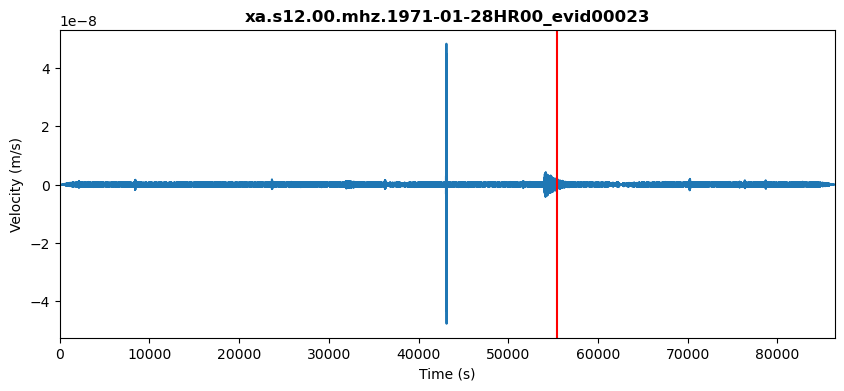

In [203]:
fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)

ax.plot(tt[ii], dd[ii])
ax.set_title(filens[ii], fontweight='bold')

# for i in pts[ii]:
ax.axvline(x = pts[ii], color='red')

# ax.axvline(x = arr, color='green')

# Make the plot pretty
ax.set_xlim([min(tt[ii]), max(tt[ii])])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

(129, 26)

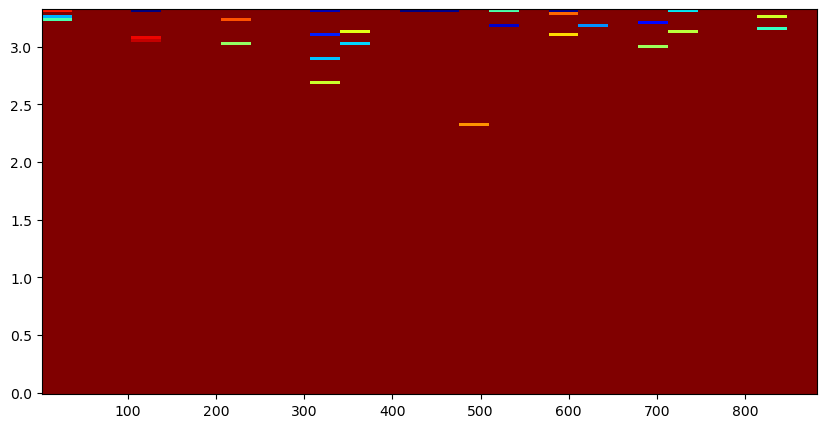

In [144]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(ft[ii][1], ft[ii][0], data[ii][0, :, :], cmap=cm.jet, vmax=5e-17).get_array().shape

In [204]:
# data.pop(ii)
# target.pop(ii)
# pts.pop(ii)
# filens.pop(ii)
# ft.pop(ii)
# dd.pop(ii)
# type.pop(ii)
# tt.pop(ii)

# assert len(data)==len(target)==len(type)==len(ft)==len(filens)==len(dd)==len(tt)==len(pts)

In [339]:
data.extend(xn)
target.extend(yn)

In [340]:
len(data)==len(target), len(data)

(True, 549)

# Training

## TF Data

In [630]:
import tensorflow as tf

In [403]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            data,
            tf.cast(target, tf.int32)
        )
    )
)

In [426]:
training_data = training_dataset.cache().shuffle(50).batch(16).prefetch(tf.data.AUTOTUNE)
training_data.as_numpy_iterator().next()[0].shape

2024-10-04 21:18:32.226584: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(16, 1, 5962)

In [427]:
len(training_data)

35

In [428]:
train = training_data.take(30)
val = training_data.skip(30).take(5)

In [429]:
len(train)

30

In [430]:
len(val)

5

In [379]:
# train.as_numpy_iterator().next()

## Training

In [500]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
        filters=8, kernel_size=3, strides=1, padding="same", activation="relu", input_shape=(1, 5962)
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='tanh')
])

model.summary()

model.compile(
    optimizer = 'adam',
    loss = 'BinaryCrossentropy',
    metrics = ['accuracy']
)

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_37 (Conv1D)              │ (None, 1, 8)           │       143,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,137 (559.13 KB)

 Trainable params: 143,137 (559.13 KB)

 Non-trainable params: 0 (0.00 B)

In [501]:
his = model.fit(
    train,
    epochs=30,
    validation_data=val
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6656 - loss: 2.1553 - val_accuracy: 0.0000e+00 - val_loss: 2.8793
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8736 - loss: 0.3653 - val_accuracy: 0.9855 - val_loss: 0.4153
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4655 - loss: 0.8496 - val_accuracy: 1.0000 - val_loss: 0.2301
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2372 - loss: 1.2840 - val_accuracy: 0.4203 - val_loss: 0.7092
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2296 - loss: 0.8402 - val_accuracy: 1.0000 - val_loss: 0.3547
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1568 - loss: 1.0908 - val_accuracy: 0.8841 - val_loss: 0.5997
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1545 - loss: 0.8704 - val_accuracy: 0.9855 - val_loss: 0.4693
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1090 - loss: 0.9764 - val_accuracy: 0.9855 - val_l

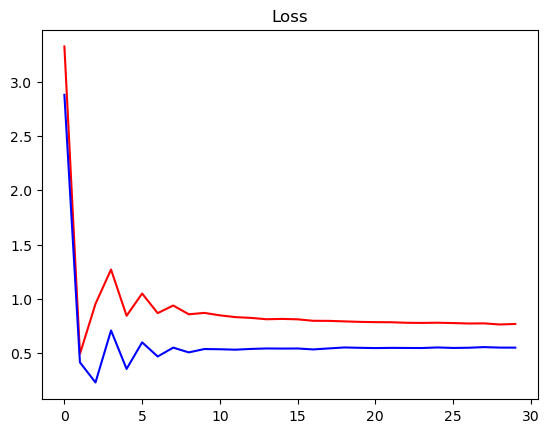

In [502]:
plt.title('Loss')
plt.plot(his.history['loss'], 'r')
plt.plot(his.history['val_loss'], 'b')
plt.show()

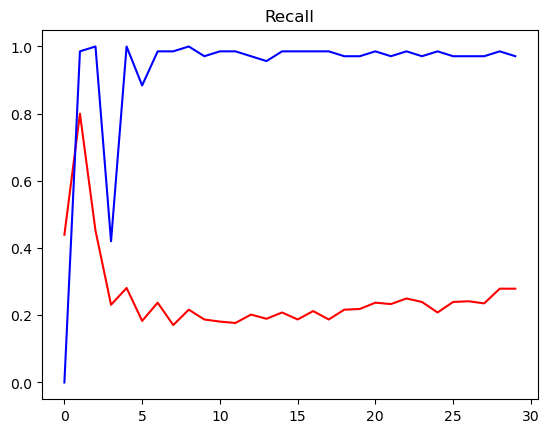

In [503]:
plt.title('Recall')
plt.plot(his.history['accuracy'], 'r')
plt.plot(his.history['val_accuracy'], 'b')
plt.show()

In [629]:
target[50]

array([[1]])

In [628]:
model.predict(data[50][None, :])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[0.44910216]], dtype=float32)

# Prediction

In [458]:
from glob import glob

In [459]:
paths = glob('data/lunar/test/data/*/*mseed')
paths[:8]

['data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed',
 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed',
 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-02-07HR00_evid00014.mseed',
 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-02-18HR00_evid00016.mseed',
 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed',
 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-30HR00_evid00020.mseed',
 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-04-03HR00_evid00021.mseed',
 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-20HR00_evid00026.mseed']

In [460]:
len(paths)

96

In [461]:
test_tr = read(paths[0])[0]
test_tr.stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1969-12-16T00:00:00.178000Z
         endtime: 1969-12-17T00:00:03.498755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [462]:
test_data = test_tr.data
test_times = test_tr.times()

In [541]:
test_data = (test_data-test_data.min())/(test_data.max()-test_data.min())

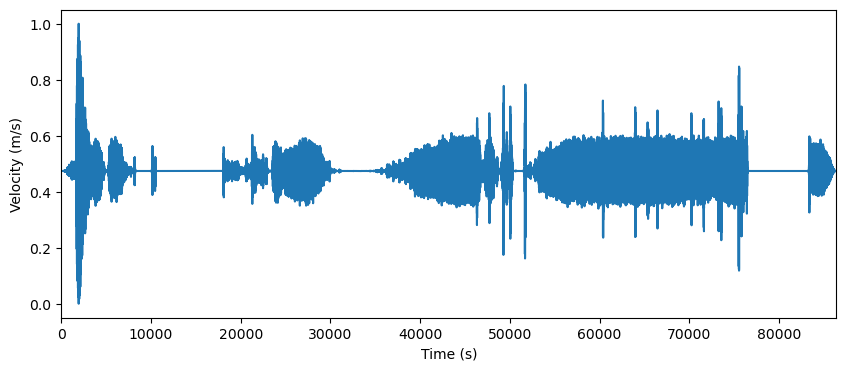

In [574]:
plot_signal(test_times, test_data)

In [588]:
arrival = []
preds = []

In [589]:
for point in range(0, test_tr.stats.npts-window, window//2):
    time_frame = test_times[point:point+window]
    data_frame = test_data[point:point+window]
    pred = model.predict(data_frame[None, None, :], verbose=False)
    preds.append(pred)
    if pred[0][0]>0.4:
        arrival.append(time_frame)

In [590]:
len(arrival)

191

In [591]:
len(preds)

191

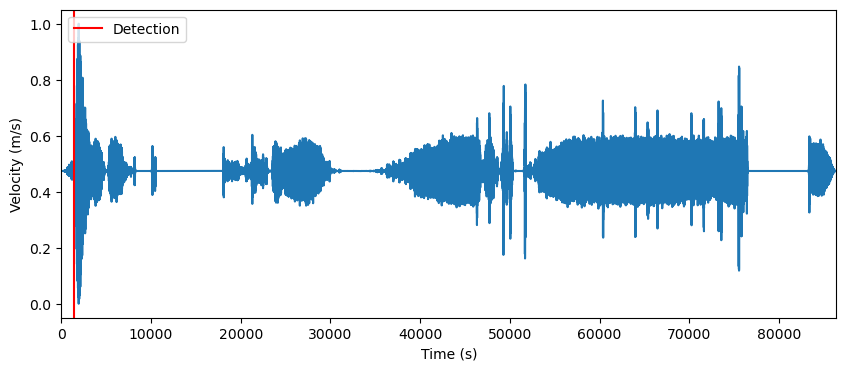

In [598]:
plot_signal(test_times, test_data, arrival[3][0])